In [2]:
import torch
import sys
sys.path.append("/home/xiaoyuz1/amazon_turk/Pytorch-Sketch-RNN")
import sketch_rnn as sr

import numpy as np
import matplotlib.pyplot as plt
import PIL

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import torchvision.models as models
import os

import part_model as pm
from importlib import reload
import pickle
reload(pm)
reload(sr)

(9548,) <class 'numpy.ndarray'>
(9548,) <class 'numpy.ndarray'>


<module 'sketch_rnn' from '/home/xiaoyuz1/amazon_turk/Pytorch-Sketch-RNN/sketch_rnn.py'>

In [3]:
import ujson as json

import read_datasets as rd
import cv2
import pandas as pd


reload(rd)

# category_name = "pig"
# obj = json.load(open(
#     '/raid/xiaoyuz1/sketch_datasets/SketchX-PRIS-Dataset/Perceptual Grouping/{}.ndjson'.format(category_name), 
#     'r'))
# folder = '/raid/xiaoyuz1/sketch_datasets/spg'


<module 'read_datasets' from '/home/xiaoyuz1/amazon_turk/read_datasets.py'>

### Mapping from body part labels to head part labels

In [4]:
dataset_mapping = {'angel': [[5], [0,1,2,3,4]],
    'butterfly': [[], []],
                   'ice_cream': [[1], [0]],
 'candle': [[0], [1,2]],
 'drill': [[1], [0]],
 'pineapple': [[1], [0]],
 'ambulance': [[1], [0]],
 'duck': [[1], [0,3]],
 'basket': [[1], [0]],
 'pig': [[5], [0,1,2,3,4]],
 'suitcase': [[1], [0]],
 'alarm_clock': [[], []],
 'flower': [[2], [0,1]],
 'house': [[1], [0]],
 'coffee_cup': [[], []],
 'bulldozer': [[], []],
 'calculator': [[], []],
 'face': [[], []],
 'campfire': [[], []],
 'airplane': [[], []],
 'backpack': [[], []],
 'ant': [[3], [0,1,2]],
 'crab': [[2], [0,1]],
 'apple': [[], []],
 'cactus': [[], []]}

dataset_mapping = {'angel': [[7], [0,1,2,3,4]]}


In [27]:
def show_these_sketches(category_name, png_indices, part_indices=[]):
    obj = json.load(open(
    '/raid/xiaoyuz1/sketch_datasets/SketchX-PRIS-Dataset/Perceptual Grouping/{}.ndjson'.format(category_name), 
    'r'))
    all_bodies = []
    for idx, drawing_raw in enumerate(obj['train_data']):
        if idx not in png_indices:
            continue
        drawing_raw_np = np.asarray(drawing_raw)
        absolute_coord = rd.to_absolute(drawing_raw)
        stroke3_rendered = rd.absolutedata2stroke3(absolute_coord, label_selected=part_indices)
        all_bodies.append(stroke3_rendered)
    
    plt.figure(figsize = (30,30))
    index = 0
    for index, part_data in enumerate(all_bodies):
        plt.subplot(10,10,index+1);
        batch_copy = np.copy(np.asarray(all_bodies[new_idx[index]]))
        if len(batch_copy) >= 5:
            
            batch_copy[:, 0] = np.cumsum(batch_copy[:,0], 0)
            batch_copy[:, 1] = np.cumsum(batch_copy[:,1], 0)

            strokes = np.split(batch_copy, np.where(batch_copy[:, 2] > 0)[0] + 1)
            for s in strokes:
                plt.plot(s[:,0], s[:,1], linewidth=2.0, c='black')

            
            canvas = plt.get_current_fig_manager().canvas
            canvas.draw()
            #
        plt.xlim(0,256)
        plt.ylim(256,0)
        plt.axis('off')

    plt.show()
    plt.close()

#### Process the selected cluster of wings

In [31]:
{"answer_1-7":"Sketch 4; Sketch 16; Sketch 19; ","answer_10-7":"Sketch 18; ","answer_12-7":"Sketch 5; ","answer_15-7":"Sketch 9; ","answer_17-7":"Sketch 7; ","answer_2-7":"Sketch 7; Sketch 19; ","answer_3-7":"Sketch 1; Sketch 6; Sketch 14; ","answer_4-7":"Sketch 15; ","answer_5-7":"Sketch 17; ","answer_7-7":"Sketch 3; ","answer_9-7":"Sketch 15; "}

{'answer_1-7': 'Sketch 4; Sketch 16; Sketch 19; ',
 'answer_10-7': 'Sketch 18; ',
 'answer_12-7': 'Sketch 5; ',
 'answer_15-7': 'Sketch 9; ',
 'answer_17-7': 'Sketch 7; ',
 'answer_2-7': 'Sketch 7; Sketch 19; ',
 'answer_3-7': 'Sketch 1; Sketch 6; Sketch 14; ',
 'answer_4-7': 'Sketch 15; ',
 'answer_5-7': 'Sketch 17; ',
 'answer_7-7': 'Sketch 3; ',
 'answer_9-7': 'Sketch 15; '}

In [30]:
txt_fname = "/home/xiaoyuz1/amazon_turk/wing_type.txt"
type_indices = [[]]
with open(txt_fname, 'r') as f:
    lines = f.readlines()
    for line in lines:
        if line == "\n":
             type_indices.append([])
        print(line)
        line_chunks = line.split("\t")
        line_chunks = [x.strip() for x in line_chunks]
        line_parts = []
        for x in line_chunks:
            if x.startswith("Sketch"):
                # line_parts.append(x)
                for y in x.split(";"):
                    y = y.strip()
                    if y.startswith("Sketch"):
                        idx = int(y.split(" ")[1])
                        line_parts.append(idx)
        type_indices[-1] += line_parts

Type: tube shaped

answer_1-7	answer_10-7	answer_11-7

Sketch 1; Sketch 6; 	Sketch 3; Sketch 12; Sketch 16; 	Sketch 5; 

answer_12-7	answer_13-7	answer_14-7

Sketch 4; 	Sketch 10; 	Sketch 17; 

answer_15-7	answer_16-7	answer_17-7

Sketch 20; 	Sketch 3; Sketch 12; 	Sketch 6; 

answer_18-7	answer_19-7	answer_2-7

Sketch 4; Sketch 16; 	Sketch 9; Sketch 11; 	Sketch 13; 

answer_20-7	answer_3-7	answer_4-7

Sketch 5; 	Sketch 2; Sketch 7; Sketch 19; 	Sketch 9; Sketch 19; 

answer_5-7	answer_6-7	answer_7-7

Sketch 16; 	Sketch 8; Sketch 13; Sketch 18; 	Sketch 11; 

answer_8-7	answer_9-7

Sketch 2; Sketch 5; Sketch 12; 	Sketch 14; Sketch 20; 



Type: angled at the top and then zigzag/u-shapes at the bottom

answer_1-7	answer_10-7	answer_12-7

Sketch 2; 	Sketch 4; 	Sketch 3; Sketch 12; 

answer_13-7	answer_14-7	answer_15-7

Sketch 4; Sketch 11; 	Sketch 10; 	Sketch 6; 

answer_16-7	answer_17-7	answer_18-7

Sketch 1; 	Sketch 16; 	Sketch 10; 

answer_19-7	answer_20-7	answer_6-7

Sketch 4; Sketch 10

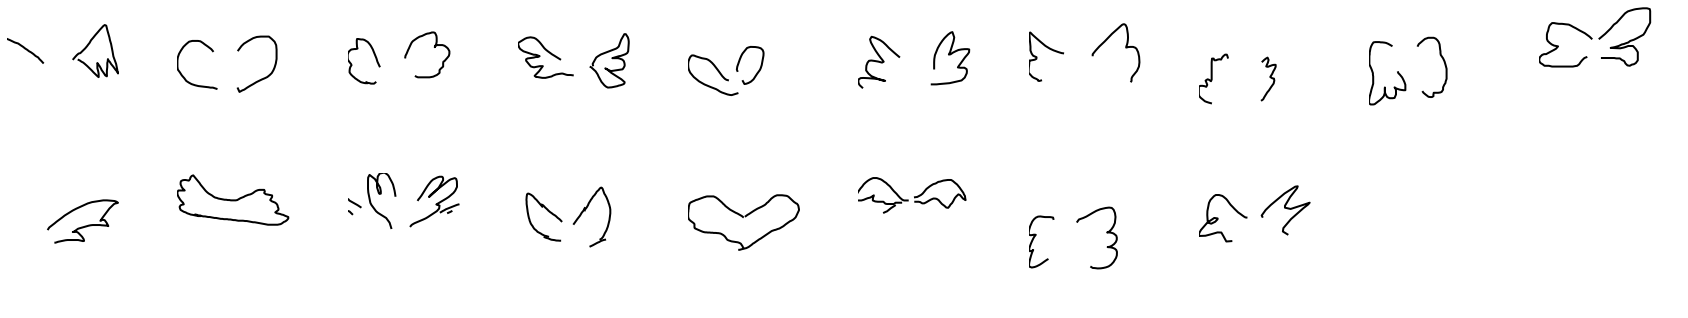

In [29]:
show_these_sketches("angel", type_indices[0], [7])

In [9]:
folder = '/raid/xiaoyuz1/sketch_datasets/spg_body'

all_bodies = []
sketch_idx = []

# ! 
skipped = None

# for category_name, part_start_end in dataset_mapping.items():
for category_name in ["angel"]:
    part_start_end = dataset_mapping[category_name]
    
    print(category_name)
    
    rendered_idxs, _ = part_start_end
    if len(rendered_idxs) == 0:
        continue
    
    obj = json.load(open(
    '/raid/xiaoyuz1/sketch_datasets/SketchX-PRIS-Dataset/Perceptual Grouping/{}.ndjson'.format(category_name), 
    'r'))
    category_folder = os.path.join(folder, category_name)
    if not os.path.exists(category_folder):
        os.mkdir(category_folder)
    
    skipped = np.ones(len(obj['train_data'])).astype(bool)
    
    for idx, drawing_raw in enumerate(obj['train_data']):
        drawing_raw_np = np.asarray(drawing_raw)
        mask = np.zeros(len(drawing_raw)).astype(bool)
        for l in rendered_idxs:
            mask[drawing_raw_np[:,-1] == l] = True
        if np.sum(mask) < 5:
            skipped[idx] = False
            continue

#         image_data_all = rd.transform_spg_2_svg_png(drawing_raw)
#         plt.figure(figsize=(5,5))
#         plt.imshow(image_data_all)
#         plt.show()
        
        
#         png_path = os.path.join(category_folder, '{}.png'.format(idx))
#         image_data = rd.transform_spg_2_svg_png(drawing_raw, draw_color=False, label_selected = rendered_idxs)
#         plt.figure(figsize=(5,5))
#         plt.imshow(image_data)
#         plt.show()
        
        absolute_coord = rd.to_absolute(drawing_raw)
        # print(np.mean(np.asarray(absolute_coord)[:,:2], axis=0))
        stroke3_rendered = rd.absolutedata2stroke3(absolute_coord, label_selected=rendered_idxs)
            
#         stroke5 = rd.absolutedata2stroke5(absolute_coord, label_selected=rendered_idxs)
#         image_data_other = rd.transform_5_stroke_2_svg_png(stroke5, output_dim=(256,256), stroke_width=2)
#         plt.figure(figsize=(5,5))
#         plt.imshow(image_data_other)
#         print(image_data_other.shape)
#         plt.show()
        
        all_bodies.append(stroke3_rendered)
        sketch_idx.append((category_name, idx))

#         if idx > 10:
#             break
#     break

angel
[111.9954659  125.62181919]
[127.64985848 105.68679969]
[112.15420875 126.24175084]
[111.20988207 132.97283177]
[134.46799723 127.30169893]
[104.22744077 112.9823421 ]
[130.57020737 112.41352892]
[124.45217458 121.52915306]
[ 97.37001372 129.22035129]
[ 89.88866954 134.13612118]
[124.13958281  92.5861321 ]
[100.29716277 114.09706322]
[113.09726444  83.5248227 ]
[138.28636757  72.80050008]
[115.31985185 105.3447724 ]
[121.0005144  117.02491182]
[119.94808673 107.56411197]
[117.2002766   65.96566725]
[ 98.84648465 140.02408436]
[119.13953074 100.61191586]
[107.88274226 132.05388362]
[123.75792507 109.5129683 ]
[ 85.24866474 105.05428596]
[116.68118467 120.14292167]
[121.80167082  79.95943816]
[ 97.98686358 121.21038732]
[118.12318229  91.66041217]
[122.43720294 112.78230104]
[123.75778894 120.17788945]
[130.86384949 110.28992819]
[102.39741613 109.43019114]
[127.42994962  88.4717329 ]
[122.9568516   71.67925101]
[136.64997432  89.29635336]
[123.8163963   87.14080691]
[109.3013468  

[132.82538024 106.79993697]
[122.54908843 107.8075172 ]
[108.40854737  89.5015486 ]
[126.12315783  91.98138582]
[110.97502956 129.449122  ]
[120.17029703  72.88217822]
[ 98.97377195 115.74194265]
[128.28597617  89.46811896]
[123.94754561  90.76337878]
[122.6517341  101.91972294]
[111.89216839 103.94301511]
[ 88.04332608 125.99918917]
[128.81406129  92.411795  ]
[107.76796643 133.50673195]
[ 51.3984486  123.18911832]
[122.36132316 112.5304804 ]
[132.6412735   84.58560636]
[118.53516535 133.62133209]
[126.9334724  108.74268219]
[106.27381793 125.10232886]
[123.32811452  90.59830016]
[ 2.68921703 33.14199551]
[111.30047256  60.5471857 ]
[136.61587119  97.8310092 ]
[119.37798546  87.77777778]
[118.50360297 131.42220661]
[134.95928594 107.11265715]
[144.69559033 105.62019915]
[127.45659555 104.27132397]
[ 98.51887203 118.62671221]
[126.56809117  97.2962963 ]
[123.97790134 111.5407435 ]
[151.0948491  102.82079646]
[ 98.17043146 126.7069818 ]
[133.545253    97.15212572]
[130.26034932  63.2694

In [10]:
new_idx = np.cumsum(skipped, 0) -1

In [11]:
len(all_bodies)

792

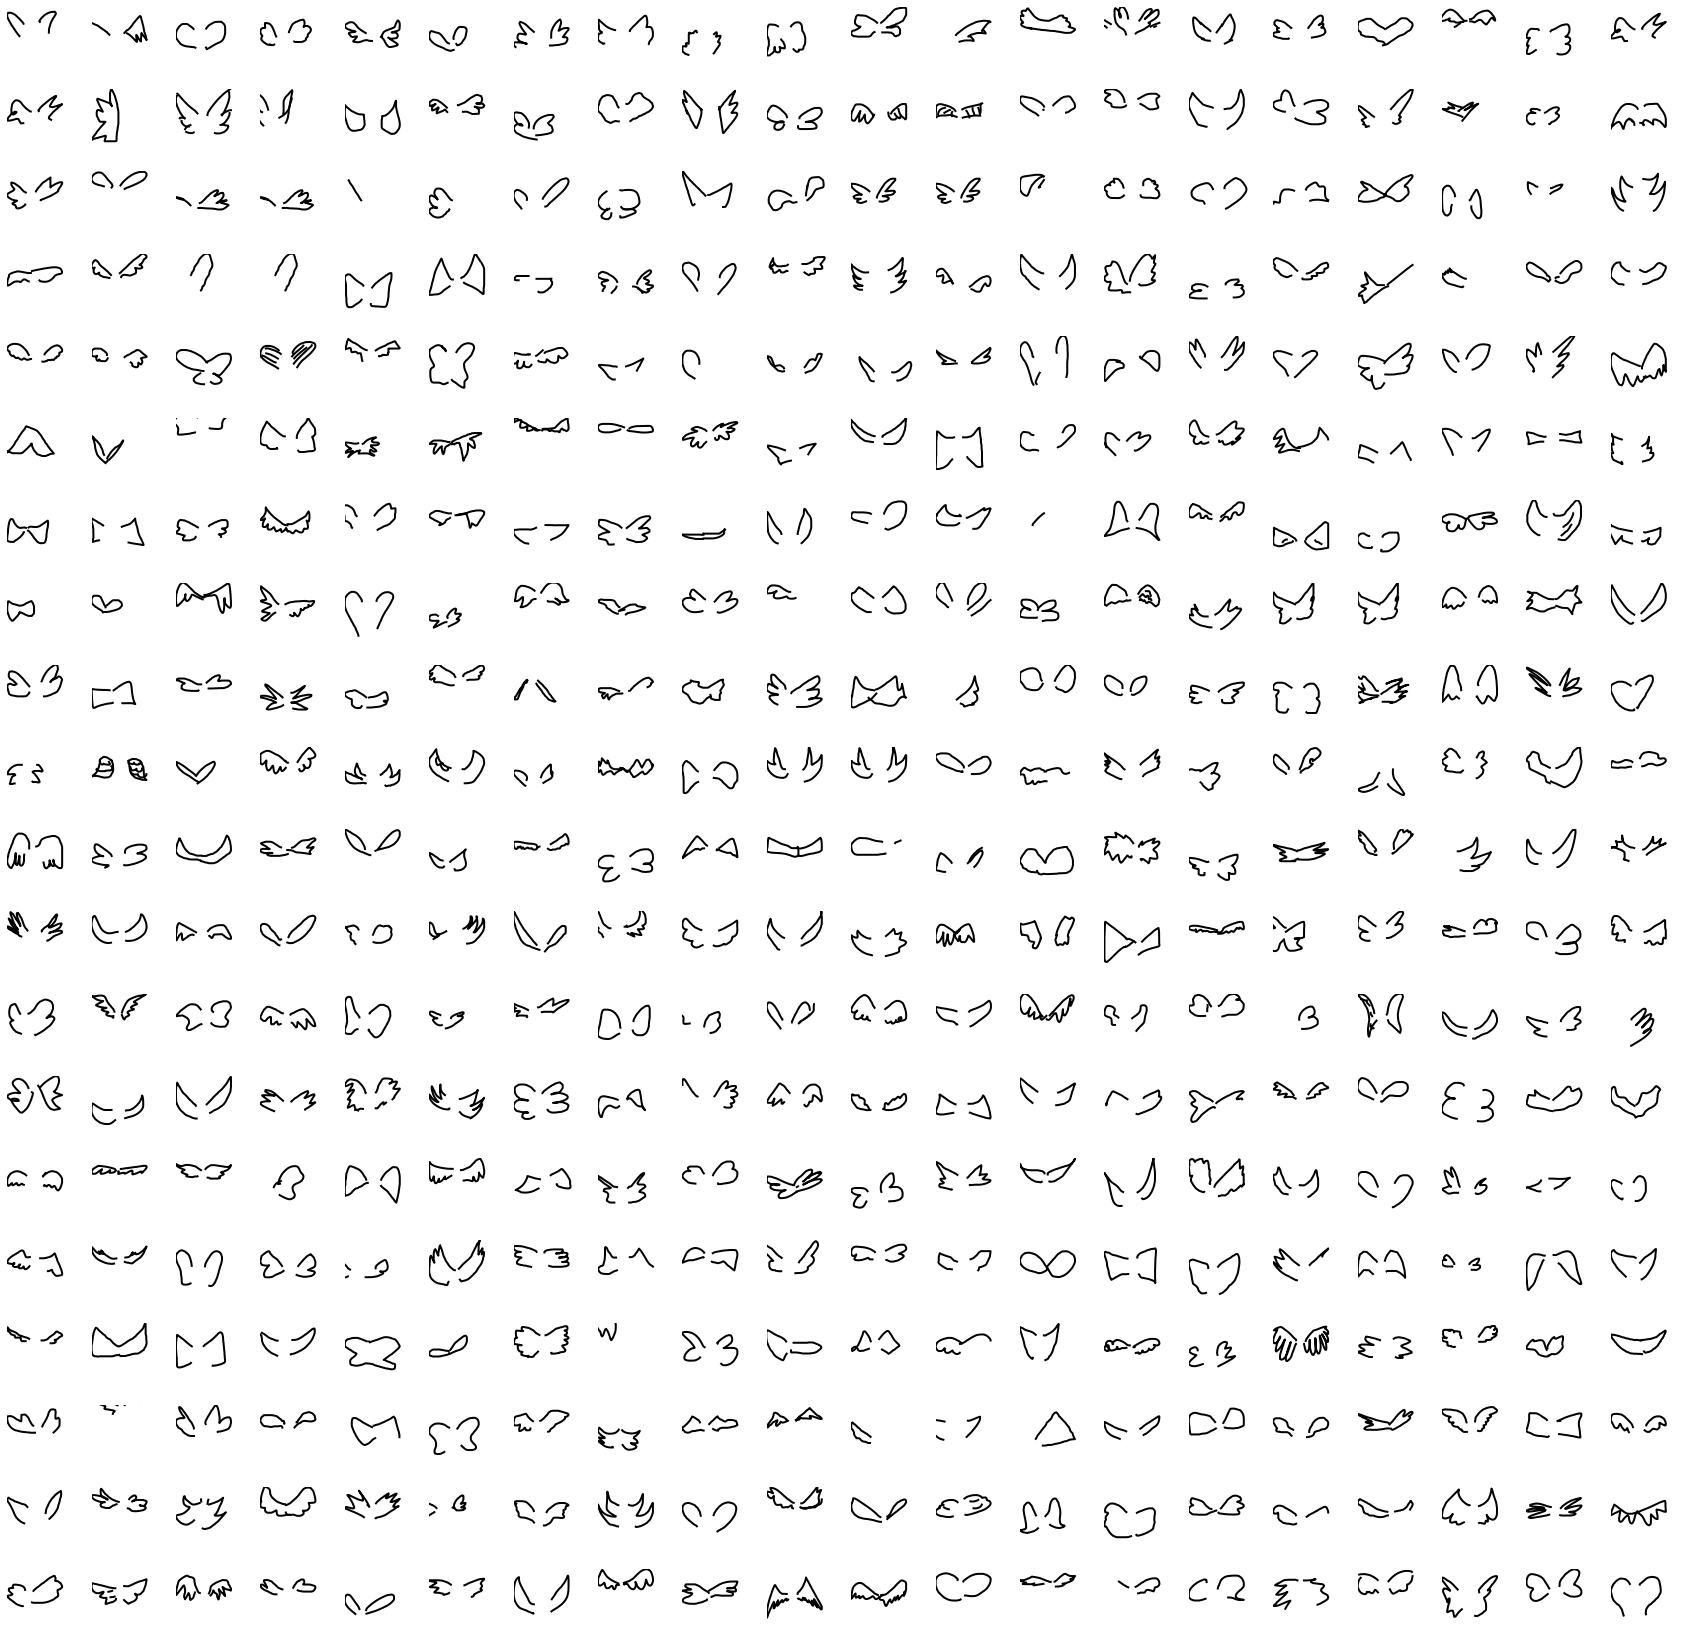

In [12]:
plt.figure(figsize = (30,30));

for index, part_data in enumerate(all_bodies[:400]):
    plt.subplot(20,20,index+1);
    batch_copy = np.copy(np.asarray(all_bodies[new_idx[index]]))
    batch_copy[:, 0] = np.cumsum(batch_copy[:,0], 0)
    batch_copy[:, 1] = np.cumsum(batch_copy[:,1], 0)

    strokes = np.split(batch_copy, np.where(batch_copy[:, 2] > 0)[0] + 1)
    for s in strokes:
        plt.plot(s[:,0], s[:,1], linewidth=2.0, c='black')

    plt.xlim(0,256)
    plt.ylim(256,0)
    canvas = plt.get_current_fig_manager().canvas
    canvas.draw()
    #
    plt.axis('off')

plt.show()
plt.close()

[ 5.68434189e-15 -1.78425176e-14]


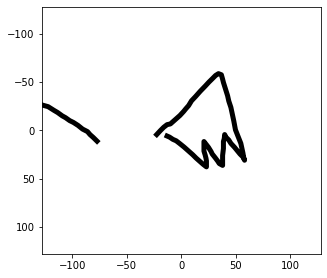

In [86]:
batch_copy = np.copy(np.asarray(all_bodies[new_idx[1]]))
batch_copy[:, 0] = np.cumsum(batch_copy[:,0], 0)
batch_copy[:, 1] = np.cumsum(batch_copy[:,1], 0)

x_max, y_max = np.max(batch_copy, axis=0)

batch_copy[:, 0] = batch_copy[:, 0] - mean_x
batch_copy[:, 1] = batch_copy[:, 1] - mean_y

strokes = np.split(batch_copy, np.where(batch_copy[:, 2] > 0)[0] + 1)
fig = plt.figure(figsize=(5,10))
ax1 = fig.add_subplot(211)
for s in strokes:
    plt.plot(s[:,0], s[:,1], linewidth=5.0, c='black')
print(np.mean(batch_copy[:,:2], axis=0))
# plt.xlim(0,256)
# plt.ylim(256,0)
plt.xlim(-128, 128)
plt.ylim(128,-128)
canvas = plt.get_current_fig_manager().canvas
canvas.draw()
#

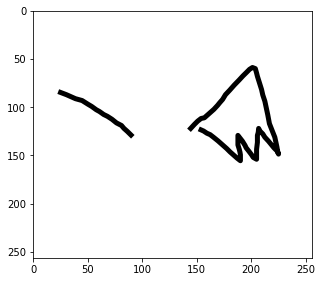

In [85]:
batch_copy = np.copy(np.asarray(all_bodies[new_idx[1]]))
batch_copy[:, 0] = np.cumsum(batch_copy[:,0], 0)
batch_copy[:, 1] = np.cumsum(batch_copy[:,1], 0)

strokes = np.split(batch_copy, np.where(batch_copy[:, 2] > 0)[0] + 1)
fig = plt.figure(figsize=(5,10))
ax1 = fig.add_subplot(211)
for s in strokes:
    plt.plot(25+s[:,0], 25+s[:,1], linewidth=5.0, c='black')

plt.xlim(0,256)
plt.ylim(256,0)
canvas = plt.get_current_fig_manager().canvas
canvas.draw()
#

In [21]:
def divide_list_ttv(total_length):
    
    num_train = int(total_length * 0.9)
    num_val = int(total_length * 0.05)
    num_test = total_length - num_train - num_val
    
    test_idx = np.random.choice(np.arange(total_length), num_test, replace=False)
    train_val = list(filter(lambda x : x not in test_idx, np.arange(total_length)))
    val_idx = np.random.choice(train_val, num_val, replace=False)
    train_idx = list(filter(lambda x : x not in val_idx, train_val))

#     train_data = [all_data[idx] for idx in train_idx]
#     val_data = [all_data[idx] for idx in val_idx]
#     test_data = [all_data[idx] for idx in test_idx]

    return train_idx, val_idx, test_idx

In [29]:
category_names = [x for (x,y) in sketch_idx]
category_idx = [y for (x,y) in sketch_idx]

In [23]:
all_train = []
all_val = []
all_test = []

t_idx, v_idx, te_idx = [],[],[]

for category_name in np.unique(category_names):
    mask = np.where(np.asarray(category_names) == category_name)[0]
    
    all_data = [all_bodies[d] for d in mask]
    t,v,te = divide_list_ttv(len(all_data))  
    
    all_train += [all_data[idx] for idx in t]
    all_val += [all_data[idx] for idx in v]
    all_test += [all_data[idx] for idx in te]
    
    t_idx += [sketch_idx[mask[d]] for d in t]
    v_idx += [sketch_idx[mask[d]] for d in v]
    te_idx += [sketch_idx[mask[d]] for d in te]

In [34]:
t_idx[4000]

('crab', 458)

In [ ]:
print(np.where((np.asarray(category_names)  == 'crab') * (np.asarray(category_idx)  == 458)))
all_train[4000]

In [ ]:
all_bodies[10270]

In [44]:
all_train = np.asarray([np.asarray(a) for a in all_train])
all_val = np.asarray([np.asarray(a) for a in all_val])
all_test = np.asarray([np.asarray(a) for a in all_test])

t_idx, v_idx, te_idx = np.asarray(t_idx,dtype=object), np.asarray(v_idx,dtype=object), np.asarray(te_idx,dtype=object)

npz_path = os.path.join('/raid/xiaoyuz1/sketch_datasets/spg_train_2/npz', 'body.npz')
npz_path = os.path.join(folder, 'body.npz')
print("Saved at: ", npz_path)
np.savez(npz_path, train=all_train, valid=all_val, test=all_test)

npz_path = os.path.join(folder, 'body_idx.npz')
print("Saved at: ", npz_path)
np.savez(npz_path, train=t_idx, valid=v_idx, test=te_idx)

Saved at:  /raid/xiaoyuz1/sketch_datasets/spg_body/body.npz
Saved at:  /raid/xiaoyuz1/sketch_datasets/spg_body/body_idx.npz


In [11]:
reload(sr)

(9548,) <class 'numpy.ndarray'>


<module 'sketch_rnn' from '/home/xiaoyuz1/amazon_turk/Pytorch-Sketch-RNN/sketch_rnn.py'>

In [13]:
sr.hp.data_location

'/raid/xiaoyuz1/sketch_datasets/spg_body/body.npz'

In [ ]:
info_path = '/raid/xiaoyuz1/sketch_datasets/spg_body/body_idx.npz'
data_path = '/raid/xiaoyuz1/sketch_datasets/spg_body/body.npz'

def draw_part(info_path,data_path):
    dataset_info = np.load(info_path, encoding='latin1', allow_pickle=True)
    for t in ['train', 'valid', 'test']:
    train_info = dataset_info['train']



In [8]:
dataset_info = \
    np.load('/raid/xiaoyuz1/sketch_datasets/spg_body/body_idx.npz', encoding='latin1', allow_pickle=True)
train_info = dataset_info['train']

hp = sr.HParams()
dataset = np.load(hp.data_location, encoding='latin1', allow_pickle=True)
orig_data = dataset['train']
orig_data, orig_kept = sr.purify(orig_data)
# orig_data = sr.normalize(orig_data)
scale_factor = sr.calculate_normalizing_scale_factor(orig_data)
print(scale_factor, sr.scale_factor)

data = sr.data
# data = sr.purify(data)
# data = sr.normalize(data)
# Nmax = max_size(data)

11.889778 11.889778


In [6]:
# seq = np.copy(orig_data[318])
# print(seq)
# print(seq.shape[0] <= sr.hp.max_seq_length and seq.shape[0] > 10)
# seq = np.minimum(seq, 1000)
# print(seq)
# seq = np.maximum(seq, -1000)
# print(seq)
# seq = np.array(seq, dtype=np.float32)
# print(seq)

In [51]:
def make_singleton_batch(data, idx):
    batch_sequences = [data[idx]]
    strokes = []
    lengths = []
    indice = 0
    for seq in batch_sequences:
        len_seq = len(seq[:,0])
        new_seq = np.zeros((sr.Nmax,5))
        new_seq[:len_seq , :2] = seq[:,:2]
        new_seq[:len_seq-1 , 2] = 1 - seq[:-1,2]
        new_seq[:len_seq, 3] = seq[:,2]
        new_seq[(len_seq-1):, 4] = 1
        new_seq[len_seq-1, 2:4] = 0
        lengths.append(len(seq[:,0]))
        strokes.append(new_seq)
        indice += 1

    return strokes[0], lengths[0]

In [139]:
idx_test = 1000
L = train_info[:,0] == 'angel'

train_category, train_idx = train_info[idx_test]
print(train_category, train_idx)

part_start_end = dataset_mapping[train_category]
rendered_idxs, _ = part_start_end

angel 318


In [22]:
len(train_info), len(orig_kept)

(9548, 9548)

In [145]:
np.where(L)[0].shape

(714,)

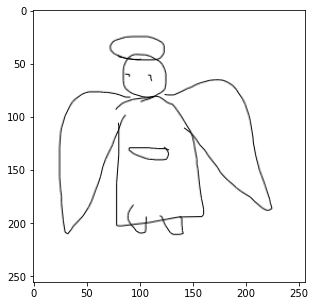

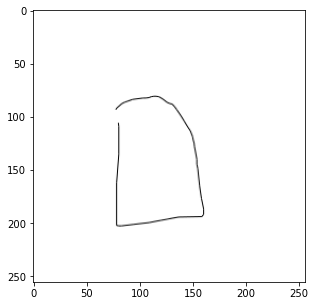

In [24]:
obj = json.load(open(
    '/raid/xiaoyuz1/sketch_datasets/SketchX-PRIS-Dataset/Perceptual Grouping/{}.ndjson'.format(train_category), 
'r'))
drawing_raw = obj['train_data'][int(train_idx)]
drawing_raw_np = np.asarray(drawing_raw)
image_data_all = rd.transform_spg_2_svg_png(drawing_raw)
plt.figure(figsize=(5,5))
plt.imshow(image_data_all)
plt.show()


image_data = rd.transform_spg_2_svg_png(drawing_raw, draw_color=False, label_selected = rendered_idxs)
plt.figure(figsize=(5,5))
plt.imshow(image_data)
plt.show()

In [60]:
def denormalize(strokes):
    """Normalize entire dataset (delta_x, delta_y) by the scaling factor."""
    data = []
    
    for seq in strokes:
        seq[:, 0:2] *= scale_factor
        data.append(seq)
    return data

In [58]:
new_idx = np.cumsum(sr.kept_idx,0) -1
print(new_idx[idx_test-1], new_idx[idx_test])
idx_test_in_data = new_idx[idx_test]
print(idx_test_in_data)

978 979
979


In [73]:
batch, lengths = make_singleton_batch(sr.data, idx_test_in_data)
batch_copy = np.copy(batch)
batch_copy = denormalize([batch_copy])[0]

In [74]:

batch_copy[:, 0] = np.cumsum(batch_copy[:,0], 0)
batch_copy[:, 1] = np.cumsum(batch_copy[:,1], 0)
batch_copy = batch_copy[:lengths]


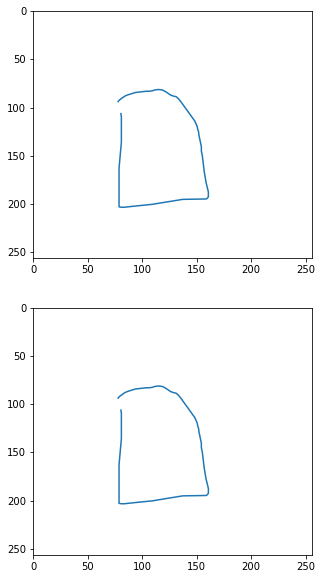

In [80]:
strokes = np.split(batch_copy, np.where(batch_copy[:, 2] < 1)[0] + 1)
fig = plt.figure(figsize=(5,10))
ax1 = fig.add_subplot(211)
for s in strokes:
    plt.plot(s[:,0]+25, s[:,1]+25)

plt.xlim(0,256)
plt.ylim(256,0)
canvas = plt.get_current_fig_manager().canvas
canvas.draw()
# pil_image = PIL.Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb())

ax1 = fig.add_subplot(212)
for s in strokes:
    plt.plot(s[:,0]+25, s[:,1]+25)

plt.xlim(0,256)
plt.ylim(256,0)
canvas = plt.get_current_fig_manager().canvas
canvas.draw()
pil_image = PIL.Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb())

978 979
979


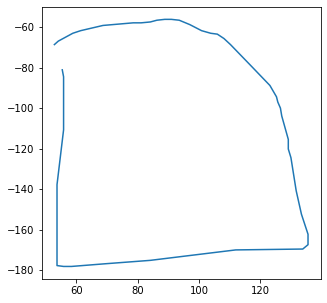

In [71]:
new_idx = np.cumsum(orig_kept,0) -1
print(new_idx[idx_test-1], new_idx[idx_test])
idx_test_in_data = new_idx[idx_test]
print(idx_test_in_data)


batch, lengths = make_singleton_batch(orig_data, idx_test_in_data)
batch_copy = np.copy(batch)
batch_copy[:, 0] = np.cumsum(batch[:,0], 0)
batch_copy[:, 1] = np.cumsum(batch[:,1], 0)
batch_copy = batch_copy[:lengths]

strokes = np.split(batch_copy, np.where(batch_copy[:, 2] < 1)[0] + 1)
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)
for s in strokes:
    plt.plot(s[:,0], -s[:,1])

# plt.xlim(0,256)
# plt.ylim(256,0)
canvas = plt.get_current_fig_manager().canvas
canvas.draw()
pil_image = PIL.Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb())

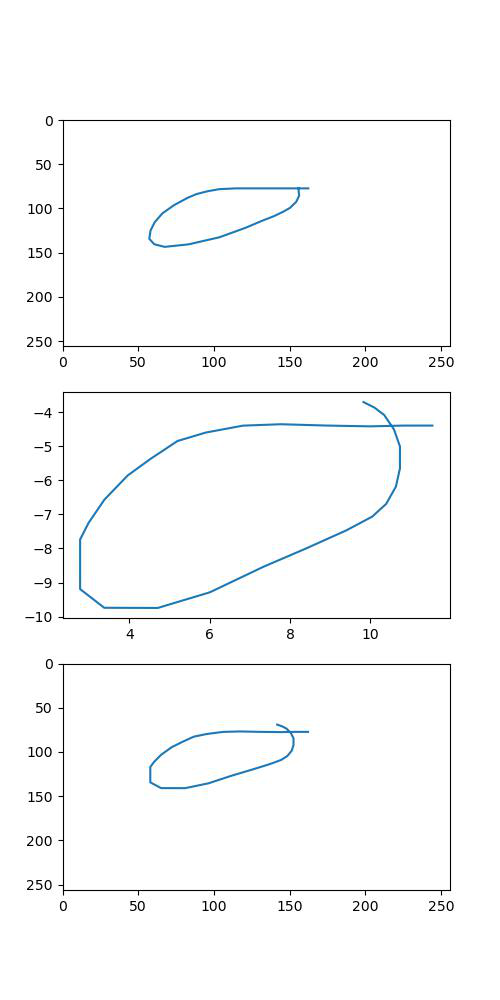

In [137]:
PIL.Image.open('/raid/xiaoyuz1/sketch_datasets/spg_body/jpg/20000_output_9_.jpg')